# Inf2 - Foundations of Data Science
## Semester 2 Week 05: Logistic regression

**Learning outcomes:** In this lab you will learn about logistic regression, interpretation of logistic regression coefficients and generating confidence intervals for logistic regression coefficients. By the end of this lab you should be able to:

- identify what transformations would be helpful to variables before applying logistic regression
- apply logistic regression to a dataset
- interpret the coefficients from application of logistic regression
- apply the bootstrap to logistic regression to obtain confidence intervals
- interpret the confidence intervals

**Remark:** The lecture topic on "Logistic regression" will be helpful background for this lab.

**Data information:** We will look at the credit approval dataset, which we have already looked at during the lectures, and we will try to reconstruct the results ourselves. The dataset was originally published on the [UCI repository with the attribute names and values changed to meaningless symbols](https://archive.ics.uci.edu/ml/datasets/credit+approval). We have used [this version of the dataset](https://github.com/KiranmayiR/Credit_Shiny), in which the attribute names have been inferred. However, we have changed some attributes. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## A. Prepare the data

Our goal is to use logistic regression to understand what features are most important in the decision of giving an applicant a credit.

**Exercise 01:** The first step is to clean our dataset.
- Load the dataset.
- Display the first 20 entries.
- Remove all entries with `NaN` values (Hint: This data set has `?` characters instead of `NaN values).
- Replace all non-numeric values by reasonable numeric values. Hint: we suggest you interpret `t` as `True` and `f` as `False`.
- For simplicity, drop the `ZipCode` column.

**Remark:** Zip codes can have an impact on credit approval. For example, ML algorithms trained on racially biased data, where the information about race has been dropped, can still learn the bias, as people from same ethnic background tend to live in the same area. However, for logistic regression the zip code is unlikely provide any information, as two zip codes that differ by a single digit can be many miles apart. We could consider whether this is the case if we used $k$-Nearest-Neighbours.

In [2]:
# Your code
credit = pd.read_csv('datasets/Credit_Approval.csv', na_values=['?'])
credit.head()
credit.dropna(inplace=True)
credit.replace('+', 1, inplace=True)
credit.replace('-', 0, inplace=True)
credit.replace('?', pd.NA, inplace=True)
credit['Gender']=credit['Gender'].replace('a', 0)
credit['Gender']=credit['Gender'].replace('b', 1)
credit['Employed']=credit['Employed'].replace('f', 0)
credit['Employed']=credit['Employed'].replace('t', 1)
credit['NoPriorDefault']=credit['NoPriorDefault'].replace('f', 0)
credit['NoPriorDefault']=credit['NoPriorDefault'].replace('t', 1)
credit['DriversLicense']=credit['DriversLicense'].replace('f', 0)
credit['DriversLicense']=credit['DriversLicense'].replace('t', 1)
credit.drop(['ZipCode'], 1, inplace=True)
credit.head()

,Gender,Age,Debt,YearsEmployed,NoPriorDefault,Employed,CreditScore,DriversLicense,Income,Approved
0,1,30.83,0.000,1.25,1,1,1,0,0,1
1,0,58.67,4.460,3.04,1,1,6,0,560,1
2,0,24.50,0.500,1.50,1,0,0,0,824,1
3,1,27.83,1.540,3.75,1,1,5,1,3,1
4,1,20.17,5.625,1.71,1,0,0,0,0,1


**Exercise 02:** Let's compare the values for the two genders. Compute the mean of the columns for each gender.

In [3]:
# Your code
credit.groupby('Gender').mean()

,Age,Debt,YearsEmployed,NoPriorDefault,Employed,CreditScore,DriversLicense,Income,Approved
Gender,,,,,,,,,
0,30.760985,5.090591,1.818498,0.551724,0.487685,2.625616,0.423645,911.389163,0.467980
1,31.946253,4.713514,2.432173,0.527716,0.416851,2.441242,0.478936,1058.345898,0.445676


**Exercise 03:**
- Create a pairplot of the data, giving approved and denied applications different colours. 
- As you can see there too many variables. Remove variables from the pairplot that you think are not displayed helpfully in a pairplot.

<Figure size 432x432 with 0 Axes>

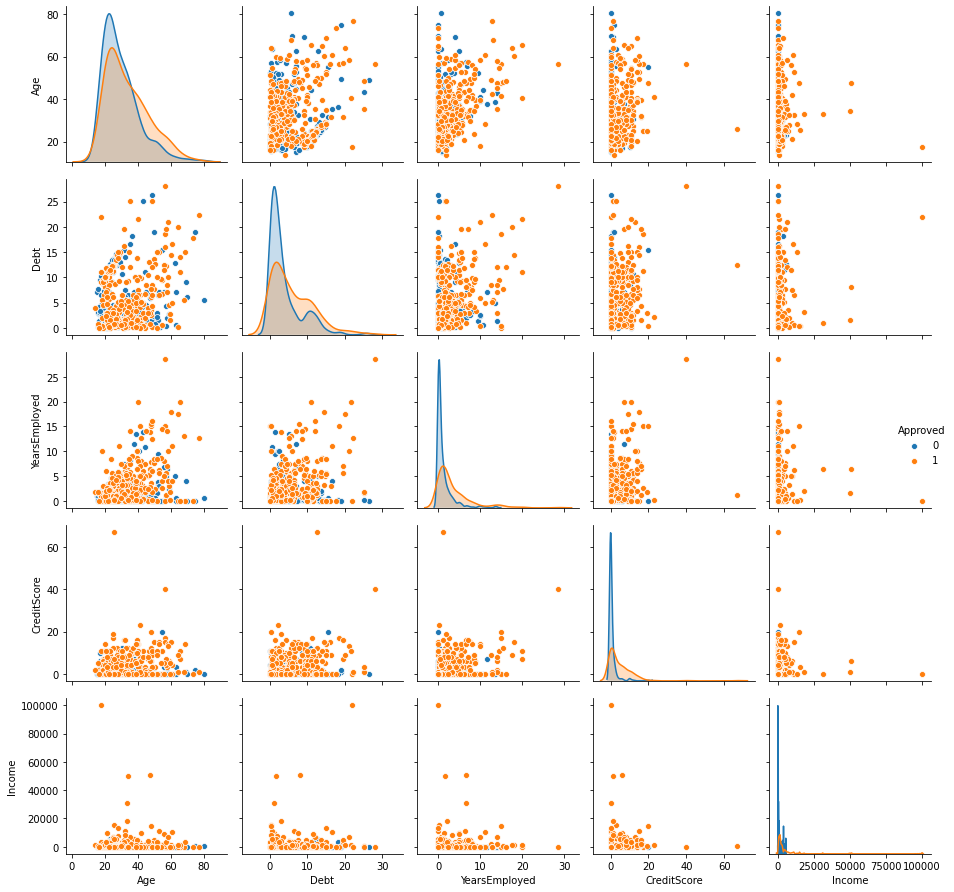

In [4]:
# Your code
plt.figure(figsize=(6,6))
# We removed the binary values, as they do not show much in a pairplot
sns.pairplot(credit.drop(['Gender', 'NoPriorDefault', 'Employed', 'DriversLicense'], 1), hue='Approved')
plt.tight_layout()

## B. Transform the dataset so logistic regression works better

**Discussion:** We have already applied the log transform to datasets previously.
- Can you remember why this can be helpful?
- For which variables in your dataset would a log transform help? Have a look at the plot above.
- Can you think of data points the log transform might not work for, and how the transform could be modified to fix this?

Your answer:
- If the data is skewed, a log-transformation can help to make the distribution of the data closer to a normal distribution.
- Both Income and Credit score seem very skewed.
- If we have a value that is equal to 0, we are taking the log of zero, which is not defined.

**Exercise 04:** 
- Replace the `Income` variable by transforming it with a function $f(x) = \log_{10} (x + 1)$ to give a version called `LogIncome`.
- Repeat the above step with the `CreditScore` variable to give a log transformed version called `LogCreditScore`.
- Plot a new pairplot to see the new distributions.

In [ ]:
# Your code
credit['LogIncome'] = np.log10(credit['Income'] + 1)
credit['LogCreditScore'] = np.log(credit['CreditScore'] + 1)
credit.drop(['Income', 'CreditScore'], 1, inplace=True)
sns.pairplot(credit.drop(['Gender', 'NoPriorDefault', 'Employed', 'DriversLicense'], 1), hue='Approved')

## C. Use sk-learn to run Logistic regression

**Exercise 05:** Let's start with the simplest case of logistic regression. We want to know whether age alone is a good feature to predict whether someone receives a credit. 
- Use the `LogisticRegression()` to run logistic regression. (Hint: You will have to supply a numpy matrix of independent variables and a vector of response variables - the Nearest Neighbours lab may remind you how to do it.)
- Store the fitted model.
- Store the intercept and the coefficient of the model in `beta0` and `beta1`, respectively. Print the values.
- Create a scatterplot, in which, to make it intelligible, you randomly sample 50 data points. The x-axis should be `Age` and the y-axis should be `Approved`.
- Add a line plot to your figure that shows the probability predicted by the logistic regression. **Hint:** The sklearn `predict_proba()` function can be applied to the fitted model.

In [ ]:
# Your code
X = credit[['Age']].to_numpy(copy=True) 
y = credit['Approved'].to_numpy()
model = LogisticRegression().fit(X, y)
beta0 = model.intercept_[0]
beta1 = model.coef_[0][0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))
plt.figure()

sns.scatterplot(x='Age', y='Approved', data=credit.sample(50))
x = np.arange(credit.Age.min(), credit.Age.max(), 0.1)
plt.plot(x, model.predict_proba(np.reshape(x, (-1, 1)))[:,1])

**Discussion:** Interpret the intercept `model.intercept_`, which is the same as $\hat\beta_0$ in the lecture notes. What quantity does it represent? Describe the characteristics of the customer for who the independent variables are all zero. Does such a customer exist?

Your answer:

This is the log odds of approval of credit for a customer aged 0. They are $e^{-1.162}=0.313$ times as likely to be approved as to be declined.

**Exercise 06:** Above we have run the logistic regression on only one independent variable in order to be able to plot it in a figure. Now, run a logistic regression on the full data.

In [ ]:
# Your code
X = credit.drop(columns=['Approved']).to_numpy(copy=True) 
y = credit['Approved'].to_numpy()
model = LogisticRegression().fit(X, y)
beta0 = model.intercept_[0]
beta1 = model.coef_[0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))

## Display as Series with names to aid explanation
coeffs = pd.Series({'Intercept': beta0})
coeffs = coeffs.append(pd.Series(beta1, index=credit.columns[credit.columns != 'Approved']))
coeffs

**Discussion:** Interpret the coefficients `model.coef_`. You may find it helpful to convert the output from sklearn back into a pandas Series with an index. Try to use language that you think would be understandable by a general audience. 

Your answer:

A weighting system is used to determine if your request for credit is approved. You start off with a  score of -2.955. If you are male (we think) you add 0.011, and you subtract -0.013 for every year of your age. You add 0.004623 for every unit of debt you have, and also add 0.14 for every year of employment. If you have not defaulted on a loan, you add 3.317. You subtract -0.082 if you're employed and -0.103 if you have a Driver's license. You round your income to the nearest 10, 100, 1000 or 10,000 etc, multiply the number of zeros in this rounded number by 0.34, and add it to the score. You do the same for your credit score (if you know it).

## D. How many of these coefficients are meaningful?

How likely is it that some of these coefficients could have arisen by chance? We'd like to find confidence intervals for each coefficient. 

**Excercise 07:** Write a bootstrap function to generate the sampling distribution of all of the coefficients. On each bootstrap iteration, we'd like to store the values of the intercept and all of the coefficients in one row of a dataframe. We'll then be able to plot distribution of the dataframe, and compute confidence intervals from the marginal distributions. We suggest you follow the pattern in the previous lab, and write:
1. A function that takes a dataframe with the same column names as the credit approval dataset, fits a logistic regression model to the dataset and returns a pandas series containing the intercept and coefficients from the logistic regression
2. A bootstrap function that takes the above function as an `estimator` argument, and, on each bootstrap replication, stores the coefficients in the row of a data frame. It should return the bootstrap samples as a dataframe with an `Intercept` column and then one column for each independent variable. The function doesn't need to return the quantiles or the bootstrap standard error. Note that the column types of the data frame should be `float`.

You can test the first function by making sure it gives you the same results as when you ran the logistic regression on the credit dataset above.  Once you've written the function, try it out on the credit dataset. You can use the `.quantile()` function on the returned data frame to compute the quantiles. You can also look at a pairplot of the bootstrap samples.

**Remark:** You may need to set the `max_iter=1000` for the `LogisticRegression()`, as otherwise the model won't converge.

In [ ]:
# Your code

def credit_linreg(credit):
    X = credit.drop(columns=['Approved']).to_numpy(copy=True) 
    y = credit['Approved'].to_numpy()
    model = LogisticRegression(max_iter=1000).fit(X, y)
    coeffs = pd.Series(model.intercept_, index=['Intercept'])
    coeffs = coeffs.append(pd.Series(model.coef_[0], index=credit.columns.drop('Approved')))
    return(coeffs)

In [ ]:
coeffs = credit_linreg(credit)

In [ ]:
def bootstrap_df(df, k=1000, estimator=credit_linreg):    
    ## Main part of bootstrap
    n = len(df)
    coeffs = estimator(df)
    x_star_est = pd.DataFrame(index=range(k), columns=coeffs.index, dtype='float')
    for i in range(k):
        x_star = df.sample(n, replace=True)
        coeffs_star = estimator(x_star)      
        x_star_est.loc[i] = coeffs_star
    
    return(x_star_est)

In [ ]:
coeffs_bs = bootstrap_df(credit)

In [ ]:
coeffs_bs.quantile([0.025, 0.975])

In [ ]:
sns.pairplot(coeffs_bs)

**Discussion** What can you conclude from the quantiles? Are any of the relationships you identified earlier open to question, because they may have arisen by chance?

Your Answer:

Only `Intercept`, `YearsEmployed`, `NoPriorDefault`, `LogIncome`  and `LogCreditScore` have 95% confidence intervals that do not include zero, which corresponds to no change in the log odds. The value zero is close to the centre of the confidence intervals for the other attributes (independent variables), suggesting that they are not significant relationships. We could imagine dropping the attributes that do not appear to be close to zero.

There are also some coefficients that are correlated. For example, bootstrap samples with a high coefficient for `Employed` tend to have a lower `LogCreditScore`.  

## E. Standardised quantities

By setting `max_iter=1000` we were able to ensure that the fitting of the logistic regression model converged. An alternative approach would be to standardise quantities. We can standardise the independent variables and then try fitting logistic regression again. However, the resulting coefficients will themselves be standardised, so we'll need to transform them back, to obtain the true figures. 

**Optional Exercise:** *If you're keen*, we suggest you just standardise the continuous variables. After running the same bootstrap function as above on the transformed data you can transform the parameters back using the formulae $\beta_{Age} = \frac{b_{Age}}{s_{Age}}$, where $b_{Age}$ is the transformed coefficient returned when the bootstrap function is applied to the transformed data.

In [ ]:
# Your code
credit_std = credit.copy()
s = credit_std.std()
xbar = credit_std.mean()
credit_std['Age'] = credit_std['Age'].transform(lambda x: (x - xbar['Age'])/s['Age'])
credit_std['LogIncome'] = credit_std['LogIncome'].transform(lambda x: (x - xbar['LogIncome'])/s['LogIncome'])
credit_std['Debt'] = credit_std['Debt'].transform(lambda x: (x - xbar['Debt'])/s['Debt'])
credit_std['YearsEmployed'] = credit_std['YearsEmployed'].transform(lambda x: (x - xbar['YearsEmployed'])/s['YearsEmployed'])
credit_std['LogCreditScore'] = credit_std['LogCreditScore'].transform(lambda x: (x - xbar['LogCreditScore'])/s['LogCreditScore'])

In [ ]:
x_star = bootstrap_df(credit_std)
x_star['Intercept'] = (x_star['Intercept'] 
                       - x_star['Age']*xbar['Age']/s['Age'] 
                       - x_star['LogIncome']*xbar['LogIncome']/s['LogIncome']
                       - x_star['Debt']*xbar['Debt']/s['Debt']
                       - x_star['YearsEmployed']*xbar['YearsEmployed']/s['YearsEmployed']
                       - x_star['LogCreditScore']*xbar['LogCreditScore']/s['LogCreditScore'])
x_star['Age'] = x_star['Age']/s['Age']
x_star['LogIncome'] = x_star['LogIncome']/s['LogIncome']
x_star['Debt'] = x_star['Debt']/s['Debt']
x_star['YearsEmployed'] = x_star['YearsEmployed']/s['YearsEmployed']
x_star['LogCreditScore'] = x_star['LogCreditScore']/s['LogCreditScore']

In [ ]:
sns.pairplot(x_star)

In [ ]:
x_star.quantile([0.025, 0.975])